# Install Dependencies + library imports

In [1]:
!pip install prophet pandas matplotlib folium gradio selenium

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import folium
from folium.plugins import MarkerCluster
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

2025-04-24 21:49:17.463166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745531357.486346   19545 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745531357.493387   19545 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Data

In [3]:
df = pd.read_csv('/kaggle/input/earthquakes-on-chile/seismic_data.csv', parse_dates=['Date(UTC)'])
df['Date(UTC)'] = pd.to_datetime(df['Date(UTC)'])
df = df[(df['Date(UTC)'] >= "2021-03-01") & (df['Date(UTC)'] < "2025-03-01")]
print(df.head())
print(df.describe())
print(df.isnull().sum())

             Date(UTC)  Latitude  Longitude  Depth  Magnitude
6  2025-02-20 06:22:05    -19.69     -69.37    114        5.0
7  2025-02-18 17:18:49    -26.29     -70.74     35        5.5
8  2025-02-16 07:08:42    -38.48     -74.12     31        5.2
9  2025-02-02 13:54:15    -30.74     -71.41     44        5.1
10 2025-01-02 20:43:35    -21.73     -69.04     98        6.0
                           Date(UTC)     Latitude    Longitude        Depth  \
count                           1175  1175.000000  1175.000000  1175.000000   
mean   2022-10-09 20:50:18.088510720   -28.232689   -70.843643    63.248511   
min              2021-03-02 16:05:35   -62.350000   -75.730000     3.000000   
25%       2021-11-26 09:21:45.500000   -32.440000   -71.560000    36.500000   
50%              2022-09-18 19:53:26   -29.320000   -71.160000    53.000000   
75%       2023-08-07 06:48:08.500000   -22.260000   -69.950000    88.000000   
max              2025-02-20 06:22:05   -14.700000   -58.390000   293.000000

In [4]:
df_daily = df.set_index('Date(UTC)').resample('D').mean().reset_index()
df_daily = df_daily[['Date(UTC)', 'Magnitude']].dropna()

# Exploratory Data Analysis

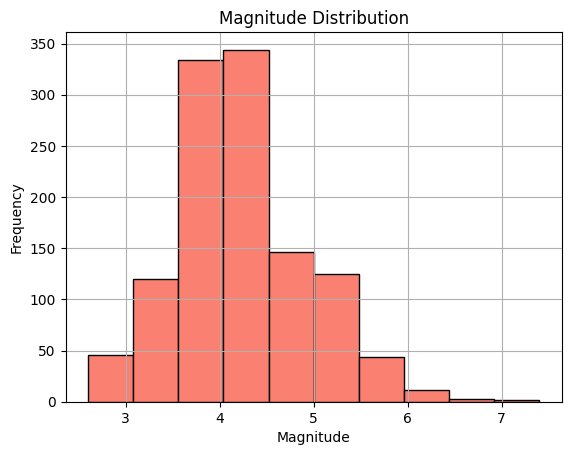

In [5]:
plt.hist(df['Magnitude'], bins=10, color='salmon', edgecolor='black')
plt.title('Magnitude Distribution')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

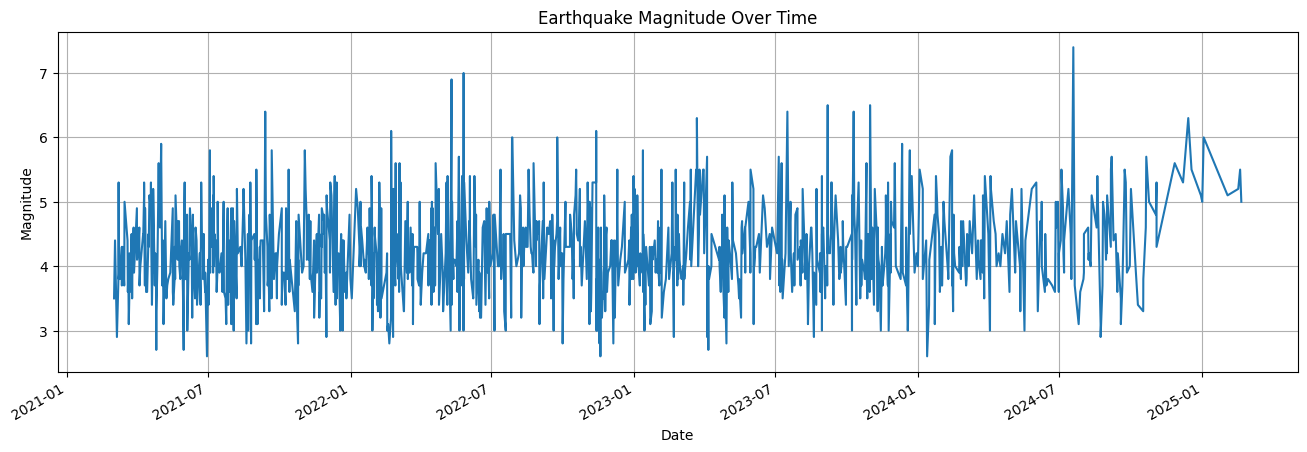

In [6]:
df.set_index('Date(UTC)')['Magnitude'].plot(figsize=(16, 5), title='Earthquake Magnitude Over Time')
plt.xlabel('Date')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

### Heatmap of Chile Datasets

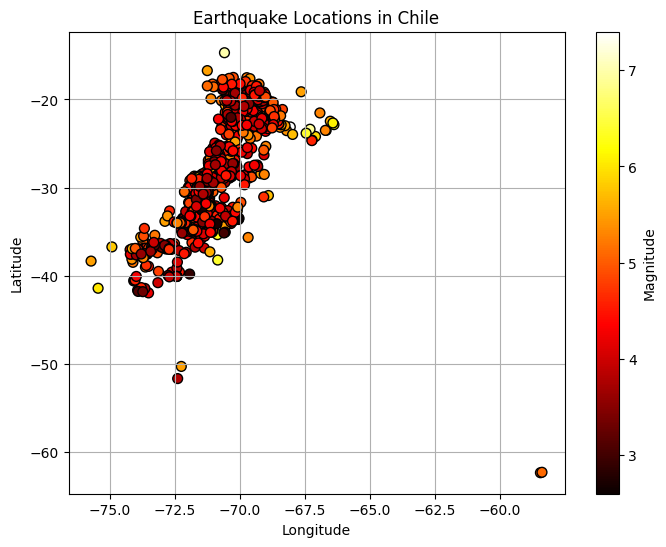

In [7]:
plt.figure(figsize=(8, 6))
plt.scatter(df['Longitude'], df['Latitude'], c=df['Magnitude'], cmap='hot', s=50, edgecolors='k')
plt.colorbar(label='Magnitude')
plt.title('Earthquake Locations in Chile')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

### DBSCAN Clustering of Earthquake records

In [8]:
coords = df[['Latitude', 'Longitude']].values

db = DBSCAN(eps=0.5, min_samples=3).fit(coords)
df['cluster'] = db.labels_

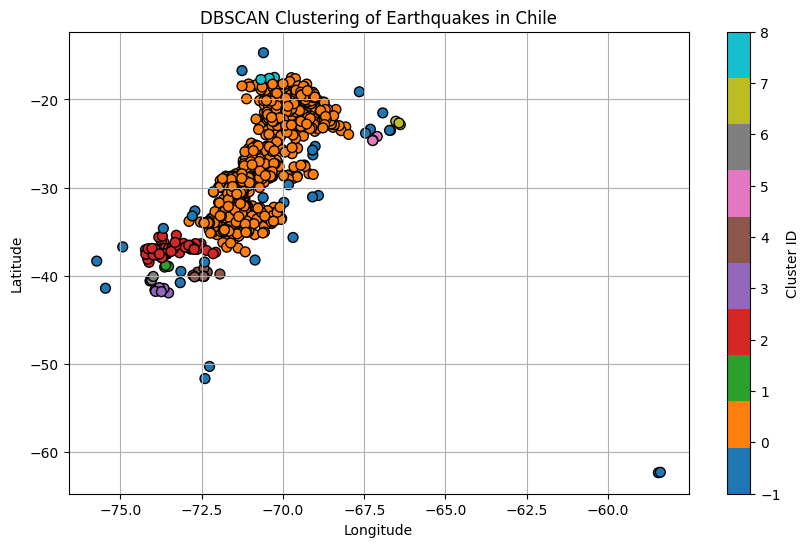

In [9]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['Longitude'], df['Latitude'], c=df['cluster'], cmap='tab10', s=50, edgecolor='k')
plt.title("DBSCAN Clustering of Earthquakes in Chile")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.colorbar(label="Cluster ID")
plt.show()


### Earthquake datapoints plotted on Chile geographical map

In [10]:
m = folium.Map(location=[-30, -71], zoom_start=5)


for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=row['Magnitude'] * 1.5,
        popup=f"Magnitude: {row['Magnitude']}<br>Depth: {row['Depth']} km",
        color='crimson',
        fill=True,
        fill_color='crimson'
    ).add_to(m)

# Save map
m.save('chile_earthquake_map.html')


### Interactive Clustered Chile earthquake map plot

In [11]:
m = folium.Map(location=[-30, -71], zoom_start=5)
marker_cluster = MarkerCluster().add_to(m)

for _, row in df.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"Mag: {row['Magnitude']}, Depth: {row['Depth']} km, Cluster: {row['cluster']}"
    ).add_to(marker_cluster)

m.save('chile_clustered_earthquake_map.html')


### ANN for earthquake prediction

In [12]:
df = df.sort_values('Date(UTC)').reset_index(drop=True)

# Keep only date and magnitude for LSTM
data = df[['Date(UTC)', 'Magnitude']].copy()
data.set_index('Date(UTC)', inplace=True)

# Normalize magnitudes for better training
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_mags = scaler.fit_transform(data[['Magnitude']])


In [13]:
seq_length = 7
X, y = [], []

for i in range(len(scaled_mags) - seq_length):
    X.append(scaled_mags[i:i+seq_length].flatten())
    y.append(scaled_mags[i+seq_length][0])

X = np.array(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [14]:
ann_model = Sequential([
    Dense(64, activation='relu', input_shape=(seq_length,)),
    Dense(32, activation='relu'),
    Dense(1)
])

ann_model.compile(optimizer='adam', loss='mse')
ann_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745531363.499705   19545 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745531363.500352   19545 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,625 (10.25 KB)

 Trainable params: 2,625 (10.25 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = ann_model.fit(X_train, y_train, epochs=100, batch_size=9, validation_data=(X_test, y_test))

Epoch 1/100


I0000 00:00:1745531365.703213   19605 service.cc:148] XLA service 0x7ec8c4008910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745531365.703252   19605 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745531365.703257   19605 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745531365.814397   19605 cuda_dnn.cc:529] Loaded cuDNN version 90300


 90/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0276

I0000 00:00:1745531366.351904   19605 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0270 - val_loss: 0.0276
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0203 - val_loss: 0.0255
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0219 - val_loss: 0.0249
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0195 - val_loss: 0.0246
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0215 - val_loss: 0.0245
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0210 - val_loss: 0.0244
Epoch 7/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0200 - val_loss: 0.0262
Epoch 8/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0205 - val_loss: 0.0260
Epoch 9/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0200 - val_loss: 0.0248
Epoch 10/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0195 - val_loss: 0.0274
Epoch 11/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0193 - val_loss: 0.0251
Epoch 12/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [44]:
y_pred = ann_model.predict(X_test)

# Inverse transform
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.legend()
plt.title("Predicted vs Actual Earthquake Magnitudes")
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.savefig("model_ANN.png")
plt.show()

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

In [17]:
# Start with the last known sequence
last_seq = scaled_mags[-seq_length:].flatten()
future_preds = []

for _ in range(14):
    input_seq = last_seq.reshape(1, -1)
    pred = ann_model.predict(input_seq)[0][0]
    future_preds.append(pred)
    
    # Update the sequence
    last_seq = np.append(last_seq[1:], pred)

# Inverse transform to get actual magnitudes
future_mags = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

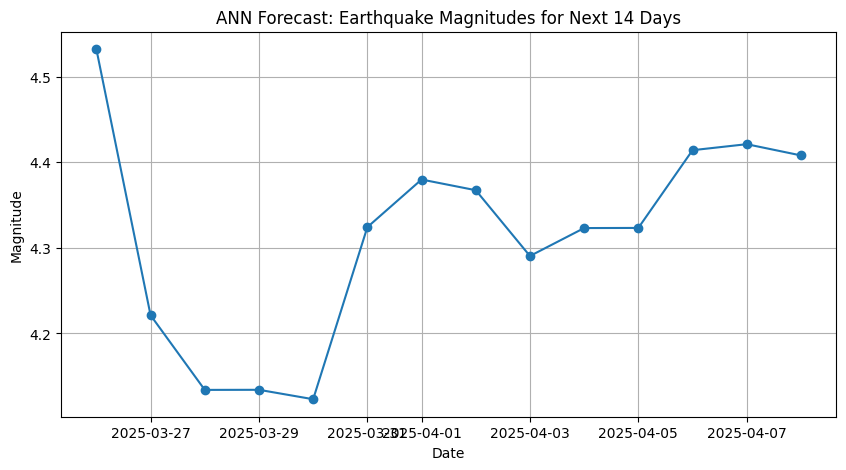

In [21]:
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime

last_date = datetime.strptime("25-3-2025", "%d-%m-%Y")
future_dates = [last_date + timedelta(days=i) for i in range(1, 15)]

plt.figure(figsize=(10, 5))
plt.plot(future_dates, future_mags, marker='o', linestyle='-', label='Forecast')
plt.title('ANN Forecast: Earthquake Magnitudes for Next 14 Days')
plt.xlabel('Date')
plt.ylabel('Magnitude')
plt.grid(True)
plt.savefig("earthquake_forecast_ann.png")
plt.show


### Prophet Prediction for Earthquakes

21:49:47 - cmdstanpy - INFO - Chain [1] start processing
21:49:47 - cmdstanpy - INFO - Chain [1] done processing


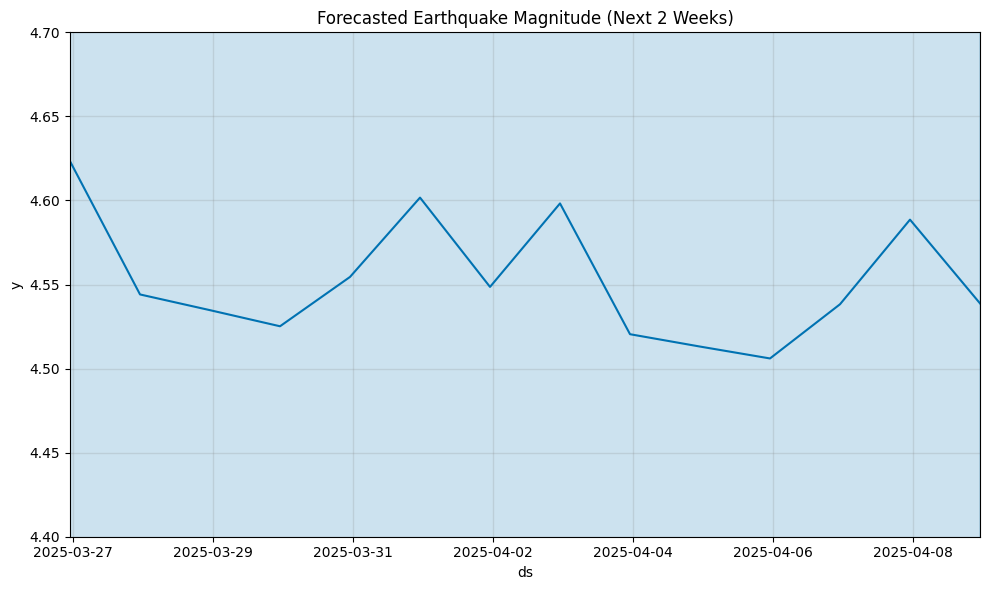

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# Load your daily magnitude data
df_daily = pd.read_csv("/kaggle/input/earthquakes-on-chile/seismic_data.csv", parse_dates=['Date(UTC)'])

# Prepare data
df_prophet = df_daily.rename(columns={'Date(UTC)': 'ds', 'Magnitude': 'y'})

# Initialize and fit the model
model = Prophet()
model.fit(df_prophet)

# Create future dataframe (next 14 days)
future = model.make_future_dataframe(periods=14, freq='D')

# Forecast
forecast = model.predict(future)

# Filter for next 14 days
last_date = df_prophet['ds'].max()
forecast_next_14_days = forecast[forecast['ds'] > last_date]

# Plot
fig = model.plot(forecast)
plt.title('Forecasted Earthquake Magnitude (Next 2 Weeks)')
plt.xlim(forecast_next_14_days['ds'].min(), forecast_next_14_days['ds'].max())
plt.ylim(4.4, 4.7)
plt.tight_layout()
plt.grid(True)
plt.savefig("earthquake_forecast_prophet.png")
plt.show()


### Location prediction ANN

In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load and preprocess
df = pd.read_csv("/kaggle/input/earthquakes-on-chile/seismic_data.csv", parse_dates=['Date(UTC)'])
df = df.sort_values('Date(UTC)')

features = df[['Magnitude', 'Depth', 'Latitude', 'Longitude']].copy()

scaler = MinMaxScaler()
scaled = scaler.fit_transform(features)

# Create sequences
seq_length = 10
X, y = [], []

for i in range(len(scaled) - seq_length):
    sequence = scaled[i:i+seq_length, :].flatten()  # shape: (40,)
    target = scaled[i+seq_length, 2:4]              # [Latitude, Longitude]
    X.append(sequence)
    y.append(target)

X = np.array(X)  # shape: (samples, 40)
y = np.array(y)  # shape: (samples, 2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

ann_model_loc = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dense(2)  # Output: Latitude and Longitude
])

ann_model_loc.compile(optimizer='adam', loss='mse', metrics=['mae'])
ann_model_loc.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 128)                 │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,650 (61.13 KB)

 Trainable params: 15,650 (61.13 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
history = ann_model_loc.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0272 - mae: 0.1261 - val_loss: 0.0106 - val_mae: 0.0771
Epoch 2/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0122 - mae: 0.0857 - val_loss: 0.0097 - val_mae: 0.0751
Epoch 3/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0106 - mae: 0.0809 - val_loss: 0.0096 - val_mae: 0.0746
Epoch 4/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0106 - mae: 0.0806 - val_loss: 0.0104 - val_mae: 0.0761
Epoch 5/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0103 - mae: 0.0786 - val_loss: 0.0098 - val_mae: 0.0752
Epoch 6/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0106 - mae: 0.0796 - val_loss: 0.0093 - val_mae: 0.0759
Epoch 7/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093 - mae: 0.0758 - val_loss: 0.0094 - val_mae: 0.0747
Epoch 8/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097 - mae: 0.0770 - val_loss: 0.0093 - val_mae: 0.0751
Epoch 9/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - l

In [41]:
# Start from last known sequence
last_seq = scaled[-seq_length:, :].copy()

future_preds_ann = []

for _ in range(14):
    input_flat = last_seq.flatten().reshape(1, -1)
    
    pred_scaled = ann_model_loc.predict(input_flat, verbose=0)
    future_preds_ann.append(pred_scaled[0])

    # Fake next input using last magnitude/depth with predicted lat/lon
    last_mag, last_depth = last_seq[-1, 0], last_seq[-1, 1]
    next_row = np.array([last_mag, last_depth, *pred_scaled[0]])

    # Slide window
    last_seq = np.vstack([last_seq[1:], next_row])

# Inverse transform coordinates
future_preds_ann = np.array(future_preds_ann)

latlon_scaler = MinMaxScaler()
latlon_scaler.min_, latlon_scaler.scale_ = scaler.min_[2:4], scaler.scale_[2:4]
pred_coords_ann = latlon_scaler.inverse_transform(future_preds_ann)


In [42]:
import folium

m = folium.Map(location=[-30, -71], zoom_start=5)

for i, coords in enumerate(pred_coords_ann):
    folium.Marker(
        location=coords.tolist(),
        popup=f"ANN Prediction {i+1}: Lat={coords[0]:.2f}, Lon={coords[1]:.2f}",
        icon=folium.Icon(color='green')
    ).add_to(m)

m.save("ann_next_14_earthquakes_map.html")


In [48]:
import gradio as gr

# Asset paths
image1 = "https://ishaanchr.github.io/Maps/magnitude_plot.png"
image2 = "https://ishaanchr.github.io/Maps/earthquake_forecast_ann.png"
image3 = "https://ishaanchr.github.io/Maps/model_LSTM.png"
image4 = "https://ishaanchr.github.io/Maps/model_ANN.png"

# Iframes
iframe_simple_map = """
<iframe src="https://ishaanchr.github.io/Maps/chile_earthquake_map.html" width="100%" height="500" style="border: none; border-radius: 8px;"></iframe>
"""

iframe_clustered_map = """
<iframe src="https://ishaanchr.github.io/Maps/chile_clustered_earthquake_map.html" width="100%" height="500" style="border: none; border-radius: 8px;"></iframe>
"""

# Explanations
image_explanation1 = """
<p style="font-size: 16px;">
The images above show earthquake trends in Chile. The left image visualizes all recorded earthquakes to date, giving a historical context of seismic activity.
The right image shows forecasted earthquake magnitudes for the next two weeks using an ANN model trained on recent data.
</p>
"""

image_explanation2 = """
<p style="font-size: 16px;">
The LSTM model (shown left) fails to capture the high variability in earthquake magnitudes, resulting in overly smoothed predictions that hover around the mean.
This suggests the model struggles with the noisy, non-seasonal nature of the data. In contrast, the ANN model (shown right) reacts better to rapid fluctuations, aligning more closely with the actual magnitudes and providing more accurate short-term predictions.
</p>
"""

iframe_explanation3 = """
<p style="font-size: 16px;">
The first map displays all recorded earthquake locations in Chile, plotted as individual markers to give a complete spatial overview of seismic activity.
The second map applies clustering to group nearby earthquake events, making it easier to identify regions with concentrated seismic activity and reducing visual clutter for better interpretation.
</p>
"""

# Gradio App with centered layout
with gr.Blocks(title="Chile Earthquake Monitoring Dashboard") as demo:
    
    # Custom CSS for centered content
    gr.HTML("""
    <style>
        .centered-container {
            max-width: 700px;
            margin: 0 auto;
            padding: 20px;
        }
    </style>
    <div class='centered-container'>
    """)

    gr.Markdown("# 🌍 Chile Earthquake Monitoring Dashboard")

    with gr.Row():
        with gr.Column():
            gr.Image(image1, label="Historical Earthquakes")
        with gr.Column():
            gr.Image(image2, label="Predicted Earthquakes (Next 2 Weeks)")
    gr.HTML(image_explanation1)

    with gr.Row():
        with gr.Column():
            gr.Image(image3, label="LSTM Prediction")
        with gr.Column():
            gr.Image(image4, label="ANN Prediction")
    gr.HTML(image_explanation2)

    with gr.Row():
        with gr.Column():
            gr.HTML(iframe_simple_map)
        with gr.Column():
            gr.HTML(iframe_clustered_map)
    gr.HTML(iframe_explanation3)

    # Close the centered div
    gr.HTML("</div>")

demo.launch()


* Running on local URL:  http://127.0.0.1:7863
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://ecb17a7d9514675eef.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
